<a href="https://colab.research.google.com/github/santosh5541/DDPM/blob/main/DA_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title ⬇️ Setup (Installs & Imports)
import os, math, random, glob, time, shutil, csv, json, tempfile
from dataclasses import dataclass
from pathlib import Path
from typing import List, Dict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid, save_image

# libs for metrics and UI
!pip -q install lpips==0.1.4 scikit-image==0.24.0 gradio==4.44.0 opencv-python-headless==4.10.0.84
import lpips, gradio as gr, cv2
from skimage.metrics import peak_signal_noise_ratio as psnr_metric, structural_similarity as ssim_metric
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 158.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 128.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 133.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 17.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires websockets>=14.0, but you have websockets 12.0 which is incompatible.
google-adk 1.14.1 requires websockets<16.0.0,>=15.0.1, but you have websockets 12.0 which is incompatible.
google-genai 1.41.0 requires websockets<15.1.0,>=13.0

In [2]:
#@title 🔗 Mount Google Drive
try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
    ROOT = "/content"
    IN_COLAB = True
except Exception as e:
    print("Not in Colab or drive mount skipped:", e)
    ROOT = "."
    IN_COLAB = False
print("ROOT:", ROOT)


Mounted at /content/drive
ROOT: /content


In [3]:
#@title ⚙️ CONFIG — paths, hparams, annotation knobs
@dataclass
class Config:
    # INPUT SPLITS (your Drive folders)
    train_dir: str = "/content/drive/MyDrive/PROJECT_DATA/DIV2K_train_HR"
    valid_dir: str = "/content/drive/MyDrive/PROJECT_DATA/DIV2K_valid_HR"

    # CURATION OUTPUTS
    curated_root: str = "/content/data_curated"   # will write paired data here
    manifest_csv: str = "/content/data_curated/manifest.csv"

    # IMAGE & LOADER
    img_size: int = 256
    channels: int = 3
    batch_size: int = 8
    num_workers: int = 2

    # DIFFUSION
    T: int = 1000
    beta_start: float = 1e-4
    beta_end: float = 0.02
    parameterization: str = "eps"

    # CONDITIONAL DDPM (condition on noisy observation y)
    conditioning: str = "noisy_obs"  # "noisy_obs" | "none"

    # SYNTHETIC NOISE BANK (for auto-pair generation)
    gaussian_sigmas: List[float] = None
    jpeg_qualities: List[int] = None
    motion_sizes: List[int] = None  # blur repeats (proxy for motion)

    # TRAINING
    epochs: int = 20
    lr: float = 2e-4
    grad_clip: float = 1.0
    project_dir: str = "/content/ddpm_denoise_ckpts"
    sample_every: int = 1
    save_every: int = 2

CFG = Config()
if CFG.gaussian_sigmas is None: CFG.gaussian_sigmas = [0.05, 0.1, 0.2]
if CFG.jpeg_qualities is None: CFG.jpeg_qualities = [90, 70, 50]
if CFG.motion_sizes is None:   CFG.motion_sizes = [1, 3, 5]

# sanity check
for p in [CFG.train_dir, CFG.valid_dir]:
    assert os.path.exists(p), f"Not found: {p}"
print(CFG)


Config(train_dir='/content/drive/MyDrive/PROJECT_DATA/DIV2K_train_HR', valid_dir='/content/drive/MyDrive/PROJECT_DATA/DIV2K_valid_HR', curated_root='/content/data_curated', manifest_csv='/content/data_curated/manifest.csv', img_size=256, channels=3, batch_size=8, num_workers=2, T=1000, beta_start=0.0001, beta_end=0.02, parameterization='eps', conditioning='noisy_obs', gaussian_sigmas=[0.05, 0.1, 0.2], jpeg_qualities=[90, 70, 50], motion_sizes=[1, 3, 5], epochs=20, lr=0.0002, grad_clip=1.0, project_dir='/content/ddpm_denoise_ckpts', sample_every=1, save_every=2)


In [4]:
#@title 🧰 Curation utilities (safe save, noise, manifest)
EXTS = (".png",".jpg",".jpeg",".bmp",".webp")

def list_images(root):
    return [p for p in glob.glob(str(Path(root)/"**" /"*.*"), recursive=True)
            if p.lower().endswith(EXTS)]

def load_rgb(path, size=None):
    img = Image.open(path).convert("RGB")
    if size: img = img.resize((size, size), Image.BICUBIC)
    return img

# safer PNG save
def save_png(img: Image.Image, path: str):
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    with open(path, "wb") as f:
        img.save(f, format="PNG")

def to_tensor01(img: Image.Image):
    return np.array(img).astype(np.float32) / 255.0

def from_tensor01(arr: np.ndarray):
    arr = np.clip(arr * 255.0, 0, 255).astype(np.uint8)
    return Image.fromarray(arr)

def add_gaussian_noise(img: Image.Image, sigma: float):
    x = to_tensor01(img)
    noisy = x + np.random.normal(0, float(sigma), x.shape).astype(np.float32)
    return from_tensor01(np.clip(noisy, 0, 1))

def add_jpeg_artifact(img: Image.Image, quality: int):
    # Use OpenCV to re-encode JPEG (avoids PIL _getencoder bug)
    q = int(max(1, min(95, quality)))
    rgb = np.array(img)    # HWC RGB
    bgr = rgb[:, :, ::-1]  # to BGR
    ok, buf = cv2.imencode(".jpg", bgr, [int(cv2.IMWRITE_JPEG_QUALITY), q])
    if not ok:
        raise RuntimeError("cv2.imencode failed for JPEG")
    bgr2 = cv2.imdecode(buf, cv2.IMREAD_COLOR)
    rgb2 = bgr2[:, :, ::-1]
    return Image.fromarray(rgb2)

def add_motion_blur(img: Image.Image, k: int):
    out = img.copy()
    for _ in range(max(1, int(k))):
        out = out.filter(ImageFilter.BLUR)
    return out

def gen_noisy_views(img: Image.Image, cfg: Config):
    outs = []
    for s in cfg.gaussian_sigmas:
        outs.append((f"gauss_{s}", add_gaussian_noise(img, s)))
    for q in cfg.jpeg_qualities:
        outs.append((f"jpeg_{q}", add_jpeg_artifact(img, q)))
    for k in cfg.motion_sizes:
        outs.append((f"blur_{k}", add_motion_blur(img, k)))
    return outs


In [5]:
#@title 🏗️ Auto-curate paired dataset + manifest.csv
def auto_curate_split(split_name: str, src_dir: str, cfg: Config, limit_per_clean:int=None):
    clean_out = Path(cfg.curated_root)/split_name/"clean"
    noisy_out = Path(cfg.curated_root)/split_name/"noisy"
    clean_out.mkdir(parents=True, exist_ok=True)
    noisy_out.mkdir(parents=True, exist_ok=True)

    rows = []
    paths = list_images(src_dir)
    print(f"[{split_name}] found {len(paths)} images")

    for idx, p in enumerate(paths, 1):
        stem = Path(p).stem
        clean = load_rgb(p, size=cfg.img_size)

        noisy_views = gen_noisy_views(clean, cfg)
        if limit_per_clean:
            noisy_views = noisy_views[:limit_per_clean]

        clean_path = str(clean_out / f"{stem}.png")
        save_png(clean, clean_path)

        for tag, y_img in noisy_views:
            noisy_path = str(noisy_out / f"{stem}__{tag}.png")
            save_png(y_img, noisy_path)
            rows.append({
                "split": split_name,
                "stem": stem,
                "tag": tag,
                "clean_path": clean_path,
                "noisy_path": noisy_path,
                "manual_tags": json.dumps({"keep": True, "notes": ""})
            })
        if idx % 100 == 0:
            print(f"  processed {idx}/{len(paths)}")

    return rows

def write_manifest(rows: List[Dict], manifest_path: str):
    Path(manifest_path).parent.mkdir(parents=True, exist_ok=True)
    with open(manifest_path, "w", newline="") as f:
        w = csv.DictWriter(f, fieldnames=["split","stem","tag","clean_path","noisy_path","manual_tags"])
        w.writeheader()
        for r in rows: w.writerow(r)

# ▶ Run curation (use a cap first to test; then None for full)
TEST_LIMIT = None  # e.g., 2 for quick check
all_rows = []
all_rows += auto_curate_split("train", CFG.train_dir, CFG, limit_per_clean=TEST_LIMIT)
all_rows += auto_curate_split("valid", CFG.valid_dir, CFG, limit_per_clean=TEST_LIMIT)
write_manifest(all_rows, CFG.manifest_csv)
print(f"Wrote manifest: {CFG.manifest_csv} with {len(all_rows)} rows")

# peek a few lines
print("Sample rows:")
with open(CFG.manifest_csv) as f:
    for i, line in enumerate(f):
        print(line.strip())
        if i > 5: break


[train] found 800 images
  processed 100/800
  processed 200/800
  processed 300/800
  processed 400/800
  processed 500/800
  processed 600/800
  processed 700/800
  processed 800/800
[valid] found 100 images
  processed 100/100
Wrote manifest: /content/data_curated/manifest.csv with 8100 rows
Sample rows:
split,stem,tag,clean_path,noisy_path,manual_tags
train,0004,gauss_0.05,/content/data_curated/train/clean/0004.png,/content/data_curated/train/noisy/0004__gauss_0.05.png,"{""keep"": true, ""notes"": """"}"
train,0004,gauss_0.1,/content/data_curated/train/clean/0004.png,/content/data_curated/train/noisy/0004__gauss_0.1.png,"{""keep"": true, ""notes"": """"}"
train,0004,gauss_0.2,/content/data_curated/train/clean/0004.png,/content/data_curated/train/noisy/0004__gauss_0.2.png,"{""keep"": true, ""notes"": """"}"
train,0004,jpeg_90,/content/data_curated/train/clean/0004.png,/content/data_curated/train/noisy/0004__jpeg_90.png,"{""keep"": true, ""notes"": """"}"
train,0004,jpeg_70,/content/

In [6]:
#@title 🗂️ Dataset (paired from manifest)
import pandas as pd

def build_transform(img_size, is_train=True):
    ops = [transforms.Resize((img_size, img_size), interpolation=Image.BICUBIC)]
    if is_train:
        ops += [transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply([transforms.ColorJitter(0.1,0.1,0.1,0.05)], p=0.3)]
    ops += [transforms.ToTensor(), transforms.Normalize([0.5]*3, [0.5]*3)]
    return transforms.Compose(ops)

def to_image_range(x):  # [-1,1] to [0,1]
    return (x.clamp(-1,1) + 1) * 0.5

class PairedFromManifest(Dataset):
    def __init__(self, manifest_csv, split, img_size=256, take_keep=True):
        self.df = pd.read_csv(manifest_csv)
        self.df = self.df[self.df["split"]==split].copy()

        if take_keep:
            def _keep(s):
                try:
                    d = json.loads(s)
                    return d.get("keep", True)
                except:
                    return True
            self.df = self.df[self.df["manual_tags"].apply(_keep)]

        self.df = self.df.reset_index(drop=True)
        self.tf = build_transform(img_size, is_train=(split=="train"))
        if len(self.df)==0:
            raise ValueError(f"No rows for split={split} (check manifest/keep flags)")

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        x0 = self.tf(Image.open(r["clean_path"]).convert("RGB"))
        y  = self.tf(Image.open(r["noisy_path"]).convert("RGB"))
        return {"x0": x0, "y": y}


In [7]:
#@title 📦 Dataloaders
def make_dataloaders_from_manifest(cfg: Config):
    train_ds = PairedFromManifest(cfg.manifest_csv, "train", img_size=cfg.img_size, take_keep=True)
    val_ds   = PairedFromManifest(cfg.manifest_csv, "valid", img_size=cfg.img_size, take_keep=True)
    train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,
                              num_workers=cfg.num_workers, pin_memory=True)
    val_loader   = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False,
                              num_workers=cfg.num_workers, pin_memory=True)
    print(f"Train rows: {len(train_ds)} | Valid rows: {len(val_ds)}")
    return train_loader, val_loader


In [8]:
#@title 📈 Diffusion schedule & loss (DDPM)
def make_beta_schedule(T, beta_start, beta_end, schedule="linear"):
    if schedule == "linear":
        return torch.linspace(beta_start, beta_end, T)
    raise NotImplementedError

class Diffusion:
    def __init__(self, T, beta_start, beta_end, device):
        self.device = device
        self.T = T
        self.betas = make_beta_schedule(T, beta_start, beta_end).to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_bar = torch.sqrt(self.alphas_bar)
        self.sqrt_one_minus_alphas_bar = torch.sqrt(1.0 - self.alphas_bar)

    def q_sample(self, x0, t, noise=None):
        if noise is None: noise = torch.randn_like(x0)
        sqrt_ab = self.sqrt_alphas_bar[t].view(-1,1,1,1)
        sqrt_omb = self.sqrt_one_minus_alphas_bar[t].view(-1,1,1,1)
        return sqrt_ab * x0 + sqrt_omb * noise, noise

    def p_losses(self, model, x0, t, cond=None, param="eps"):
        x_t, noise = self.q_sample(x0, t)
        pred = model(x_t, t) if cond is None else model(torch.cat([x_t, cond], dim=1), t)
        if param == "eps": return F.mse_loss(pred, noise)
        raise NotImplementedError


In [9]:
#@title 🧰 Time embeddings + U-Net
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim): super().__init__(); self.dim = dim
    def forward(self, time):
        device = time.device
        hd = self.dim // 2
        w = math.log(10000) / (hd - 1)
        emb = torch.exp(torch.arange(hd, device=device) * -w)
        emb = time[:, None] * emb[None, :]
        return torch.cat((emb.sin(), emb.cos()), dim=-1)

class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c, tdim):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.SiLU(), nn.Linear(tdim, out_c))
        self.b1 = nn.Sequential(nn.Conv2d(in_c, out_c, 3, padding=1), nn.GroupNorm(8, out_c), nn.SiLU())
        self.b2 = nn.Sequential(nn.Conv2d(out_c, out_c, 3, padding=1), nn.GroupNorm(8, out_c), nn.SiLU())
        self.res = nn.Conv2d(in_c, out_c, 1) if in_c != out_c else nn.Identity()
    def forward(self, x, t):
        h = self.b1(x); h = h + self.time_mlp(t)[:, :, None, None]; h = self.b2(h)
        return h + self.res(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, tdim=256, base=64):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(tdim),
            nn.Linear(tdim, tdim*4), nn.SiLU(),
            nn.Linear(tdim*4, tdim)
        )
        self.d1 = ResidualBlock(in_channels, base, tdim)
        self.d2 = ResidualBlock(base, base*2, tdim)
        self.d3 = ResidualBlock(base*2, base*4, tdim)
        self.pool = nn.MaxPool2d(2)
        self.m1 = ResidualBlock(base*4, base*4, tdim)
        self.m2 = ResidualBlock(base*4, base*4, tdim)
        self.u1 = nn.ConvTranspose2d(base*4, base*2, 2, 2); self.r1 = ResidualBlock(base*4, base*2, tdim)
        self.u2 = nn.ConvTranspose2d(base*2, base, 2, 2);   self.r2 = ResidualBlock(base*2, base, tdim)
        self.out = nn.Conv2d(base, out_channels, 1)
    def forward(self, x, t):
        t = self.time_mlp(t)
        h1 = self.d1(x, t); h2 = self.d2(self.pool(h1), t); h3 = self.d3(self.pool(h2), t)
        h = self.m1(h3, t); h = self.m2(h, t)
        h = self.u1(h); h = self.r1(torch.cat([h, h2], 1), t)
        h = self.u2(h); h = self.r2(torch.cat([h, h1], 1), t)
        return self.out(h)


In [10]:
#@title 🚂 Trainer (sampling, logging, ckpts)
def timestep_sample(b, T, device): return torch.randint(0, T, (b,), device=device, dtype=torch.long)

def ddpm_sample(model, diffusion, shape, cond=None):
    model.eval()
    x_t = torch.randn(shape, device=model.device if hasattr(model,"device") else device)
    for t in reversed(range(diffusion.T)):
        tt = torch.full((shape[0],), t, device=x_t.device, dtype=torch.long)
        eps = model(x_t, tt) if cond is None else model(torch.cat([x_t, cond], 1), tt)
        b, a, ab = diffusion.betas[t], diffusion.alphas[t], diffusion.alphas_bar[t]
        mean = (1/torch.sqrt(a)) * (x_t - ((1-a)/torch.sqrt(1-ab)) * eps)
        x_t = mean + (torch.sqrt(b) * torch.randn_like(x_t) if t>0 else 0)
    return x_t

def make_dataloaders(cfg: Config):
    return make_dataloaders_from_manifest(cfg)

class Trainer:
    def __init__(self, cfg: Config):
        self.cfg = cfg
        Path(cfg.project_dir).mkdir(parents=True, exist_ok=True)
        self.diff = Diffusion(cfg.T, cfg.beta_start, cfg.beta_end, device)
        self.lpips_fn = lpips.LPIPS(net='alex').to(device)
        self.model = None
        self.opt = None

    def build_model(self):
        in_ch = cfg.channels if cfg.conditioning=="none" else cfg.channels*2
        self.model = UNet(in_channels=in_ch, out_channels=cfg.channels).to(device)
        self.model.device = device
        self.opt = torch.optim.AdamW(self.model.parameters(), lr=cfg.lr)

    def train(self):
        train_loader, val_loader = make_dataloaders(self.cfg)
        self.build_model()
        for epoch in range(1, self.cfg.epochs+1):
            self.model.train(); epoch_loss=0.0
            for batch in train_loader:
                x0 = batch["x0"].to(device)
                cond = batch["y"].to(device) if self.cfg.conditioning=="noisy_obs" else None
                t = timestep_sample(x0.size(0), self.cfg.T, device)
                self.opt.zero_grad(set_to_none=True)
                loss = self.diff.p_losses(self.model, x0, t, cond=cond, param=self.cfg.parameterization)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.cfg.grad_clip)
                self.opt.step()
                epoch_loss += loss.item()
            print(f"[Epoch {epoch}/{self.cfg.epochs}] train loss: {epoch_loss/len(train_loader):.4f}")
            if epoch % self.cfg.sample_every == 0:
                self.sample_and_log(val_loader, epoch)
            if epoch % self.cfg.save_every == 0:
                self.save_ckpt(epoch)

    @torch.no_grad()
    def sample_and_log(self, val_loader, epoch):
        self.model.eval()
        batch = next(iter(val_loader))
        x0 = batch["x0"].to(device)
        cond = batch["y"].to(device) if self.cfg.conditioning=="noisy_obs" else None
        x_pred = ddpm_sample(self.model, self.diff, x0.shape, cond=cond)

        # quick metrics subset
        x0_np = to_image_range(x0).cpu().numpy().transpose(0,2,3,1)
        x_pred_np = to_image_range(x_pred).cpu().numpy().transpose(0,2,3,1)
        ps, ss = [], []
        for i in range(min(4, x0_np.shape[0])):
            gt = (x0_np[i]*255).astype(np.uint8); pr = (x_pred_np[i]*255).astype(np.uint8)
            ps.append(psnr_metric(gt, pr, data_range=255))
            ss.append(ssim_metric(gt, pr, channel_axis=2, data_range=255))
        print(f"Sample PSNR: {np.mean(ps):.2f} | SSIM: {np.mean(ss):.3f}")
        lp = self.lpips_fn(torch.tensor(x0_np[:1]).permute(0,3,1,2).to(device)*2-1,
                           torch.tensor(x_pred_np[:1]).permute(0,3,1,2).to(device)*2-1)
        print(f"LPIPS (first image): {lp.item():.4f}")

        # grid [GT | cond | pred]
        viz = [to_image_range(x0)]
        if cond is not None: viz.append(to_image_range(cond))
        viz.append(to_image_range(x_pred))
        grid = make_grid(torch.cat(viz, dim=0), nrow=x0.size(0))
        out_path = Path(self.cfg.project_dir)/f"epoch_{epoch:03d}_samples.png"
        save_image(grid, out_path); print("Saved:", out_path)

    def save_ckpt(self, epoch):
        p = Path(self.cfg.project_dir)/f"model_epoch_{epoch:03d}.pt"
        torch.save({"model": self.model.state_dict(), "cfg": self.cfg.__dict__}, p)
        print("Checkpoint saved:", p)

cfg = CFG
trainer = Trainer(cfg)
print("Trainer ready.")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 235MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
Trainer ready.


   split  stem         tag                                  clean_path  \
0  train     4  gauss_0.05  /content/data_curated/train/clean/0004.png   
1  train     4   gauss_0.1  /content/data_curated/train/clean/0004.png   
2  train     4   gauss_0.2  /content/data_curated/train/clean/0004.png   
3  train     4     jpeg_90  /content/data_curated/train/clean/0004.png   
4  train     4     jpeg_70  /content/data_curated/train/clean/0004.png   

                                          noisy_path  \
0  /content/data_curated/train/noisy/0004__gauss_...   
1  /content/data_curated/train/noisy/0004__gauss_...   
2  /content/data_curated/train/noisy/0004__gauss_...   
3  /content/data_curated/train/noisy/0004__jpeg_9...   
4  /content/data_curated/train/noisy/0004__jpeg_7...   

                   manual_tags  
0  {"keep": true, "notes": ""}  
1  {"keep": true, "notes": ""}  
2  {"keep": true, "notes": ""}  
3  {"keep": true, "notes": ""}  
4  {"keep": true, "notes": ""}  


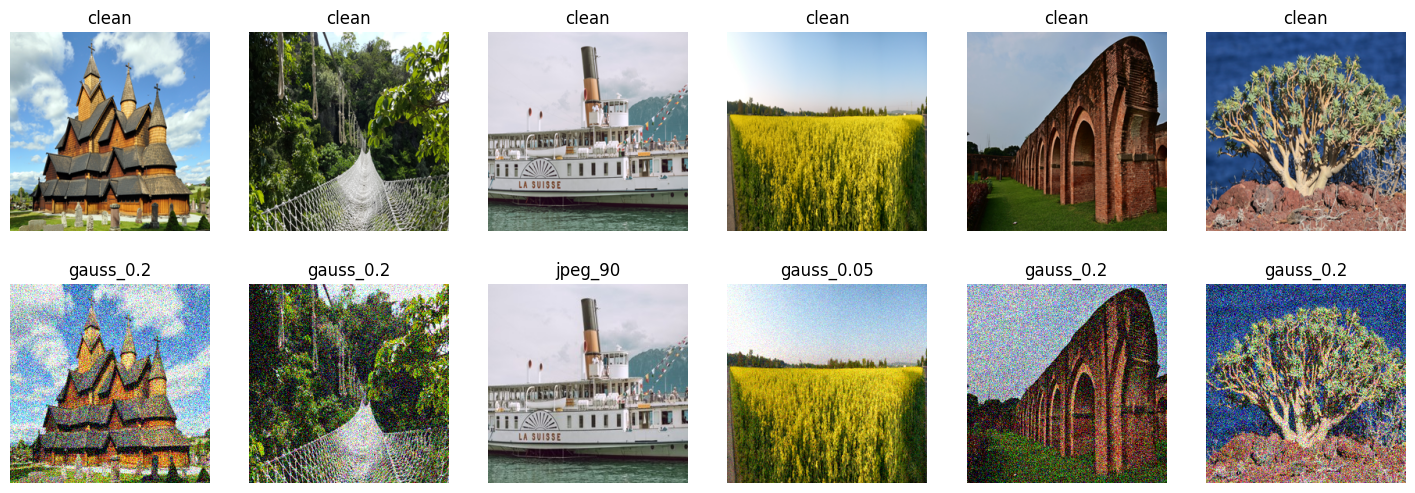

In [11]:
#@title 👀 Quick peek of curated pairs
import pandas as pd
df = pd.read_csv(CFG.manifest_csv)
print(df.head(5))

def show_pairs(df, n=6):
    rows = df.sample(min(n, len(df)), random_state=42)
    cols = n
    plt.figure(figsize=(3*cols, 6))
    for i, (_, r) in enumerate(rows.iterrows(), 1):
        c = Image.open(r["clean_path"]).convert("RGB").resize((CFG.img_size, CFG.img_size))
        y = Image.open(r["noisy_path"]).convert("RGB").resize((CFG.img_size, CFG.img_size))
        plt.subplot(2, cols, i); plt.imshow(c); plt.axis('off'); plt.title("clean")
        plt.subplot(2, cols, i+cols); plt.imshow(y); plt.axis('off'); plt.title(r["tag"])
    plt.show()

show_pairs(df[df["split"]=="train"], n=6)


In [12]:
#@title 🚀 Train DDPM on curated pairs
trainer.train()


Train rows: 7200 | Valid rows: 900
[Epoch 1/20] train loss: 0.0641
Sample PSNR: 12.68 | SSIM: 0.329
LPIPS (first image): 0.6050
Saved: /content/ddpm_denoise_ckpts/epoch_001_samples.png
[Epoch 2/20] train loss: 0.0389
Sample PSNR: 10.38 | SSIM: 0.239
LPIPS (first image): 0.7291
Saved: /content/ddpm_denoise_ckpts/epoch_002_samples.png
Checkpoint saved: /content/ddpm_denoise_ckpts/model_epoch_002.pt
[Epoch 3/20] train loss: 0.0343
Sample PSNR: 15.68 | SSIM: 0.399
LPIPS (first image): 0.5863
Saved: /content/ddpm_denoise_ckpts/epoch_003_samples.png
[Epoch 4/20] train loss: 0.0334
Sample PSNR: 16.53 | SSIM: 0.569
LPIPS (first image): 0.3335
Saved: /content/ddpm_denoise_ckpts/epoch_004_samples.png
Checkpoint saved: /content/ddpm_denoise_ckpts/model_epoch_004.pt
[Epoch 5/20] train loss: 0.0313
Sample PSNR: 7.11 | SSIM: 0.075
LPIPS (first image): 0.7288
Saved: /content/ddpm_denoise_ckpts/epoch_005_samples.png
[Epoch 6/20] train loss: 0.0306
Sample PSNR: 18.56 | SSIM: 0.737
LPIPS (first image): 

In [14]:
#@title 🧪 Inference on curated 'noisy' folder → denoised PNGs
ckpt_path = "/content/ddpm_denoise_ckpts/model_epoch_020.pt"
input_folder = str(Path(CFG.curated_root)/"valid"/"noisy")
output_folder = "/content/denoised_valid"

assert ckpt_path, "Provide a checkpoint path"
Path(output_folder).mkdir(parents=True, exist_ok=True)

ckpt = torch.load(ckpt_path, map_location=device)
for k,v in ckpt["cfg"].items():
    if hasattr(CFG, k): setattr(CFG, k, v)

in_ch = CFG.channels if CFG.conditioning=="none" else CFG.channels*2
model = UNet(in_channels=in_ch, out_channels=CFG.channels).to(device)
model.load_state_dict(ckpt["model"]); model.eval(); model.device = device
diff = Diffusion(CFG.T, CFG.beta_start, CFG.beta_end, device)

def build_transform_infer(sz): return transforms.Compose([
    transforms.Resize((sz, sz), interpolation=Image.BICUBIC),
    transforms.ToTensor(), transforms.Normalize([0.5]*3, [0.5]*3)
])

tf = build_transform_infer(CFG.img_size)
paths = [p for p in glob.glob(str(Path(input_folder)/"*")) if p.lower().endswith(EXTS)]
with torch.no_grad():
    for p in paths:
        y = tf(Image.open(p).convert("RGB")).unsqueeze(0).to(device)
        cond = y.clone() if CFG.conditioning=="noisy_obs" else None
        xhat = ddpm_sample(model, diff, y.shape, cond=cond)
        out = to_image_range(xhat)
        out_path = Path(output_folder)/f"denoised_{Path(p).stem}.png"
        save_image(out, out_path); print("Saved:", out_path)


Saved: /content/denoised_valid/denoised_0883__jpeg_90.png
Saved: /content/denoised_valid/denoised_0897__gauss_0.1.png
Saved: /content/denoised_valid/denoised_0892__jpeg_50.png
Saved: /content/denoised_valid/denoised_0840__jpeg_70.png
Saved: /content/denoised_valid/denoised_0829__gauss_0.2.png
Saved: /content/denoised_valid/denoised_0870__blur_1.png
Saved: /content/denoised_valid/denoised_0894__gauss_0.2.png
Saved: /content/denoised_valid/denoised_0893__gauss_0.05.png
Saved: /content/denoised_valid/denoised_0837__gauss_0.05.png
Saved: /content/denoised_valid/denoised_0873__jpeg_50.png
Saved: /content/denoised_valid/denoised_0877__blur_1.png
Saved: /content/denoised_valid/denoised_0847__jpeg_70.png
Saved: /content/denoised_valid/denoised_0882__jpeg_50.png
Saved: /content/denoised_valid/denoised_0815__jpeg_70.png
Saved: /content/denoised_valid/denoised_0873__blur_5.png
Saved: /content/denoised_valid/denoised_0830__gauss_0.2.png
Saved: /content/denoised_valid/denoised_0879__gauss_0.2.png
S

In [19]:
#@title 📊 Evaluate PSNR / SSIM / LPIPS (robust match)
import pandas as pd, numpy as np, lpips, torch
lpips_fn = lpips.LPIPS(net='alex').to(device).eval()

pred_folder = "/content/denoised_valid"  # set to your inference output_folder
assert os.path.exists(pred_folder), f"pred_folder not found: {pred_folder}"

# Read manifest as string to preserve leading zeros
df = pd.read_csv(CFG.manifest_csv, dtype={"stem": str, "tag": str, "clean_path": str, "noisy_path": str, "split": str})
dfv = df[df["split"]=="valid"].copy()

def norm_stem(x: str) -> str:
    s = str(x)
    if s.isdigit():
        s = s.lstrip("0")
        if s == "": s = "0"
    return s

def key_from_noisy_stem(s: str):
    if "__" in s:
        stem, tag = s.split("__", 1)
    else:
        stem, tag = s, ""
    return norm_stem(stem), tag

# Build prediction map
preds = [p for p in glob.glob(str(Path(pred_folder)/"*")) if p.lower().endswith(EXTS)]
pred_map = {}
for p in preds:
    stem = Path(p).stem
    if stem.startswith("denoised_"): stem = stem[len("denoised_"):]
    pred_map[key_from_noisy_stem(stem)] = p

psnrs, ssims, lp_list, used = [], [], [], 0

for _, r in dfv.iterrows():
    k = (norm_stem(r["stem"]), r["tag"])
    if k not in pred_map: continue
    gt = np.array(Image.open(r["clean_path"]).convert("RGB"))
    pr = np.array(Image.open(pred_map[k]).convert("RGB"))

    psnrs.append(psnr_metric(gt, pr, data_range=255))
    ssims.append(ssim_metric(gt, pr, channel_axis=2, data_range=255))

    # LPIPS expects float32 tensors in [-1, 1]
    gtt = torch.from_numpy(gt).to(device=device, dtype=torch.float32).permute(2,0,1).unsqueeze(0) / 127.5 - 1.0
    prt = torch.from_numpy(pr).to(device=device, dtype=torch.float32).permute(2,0,1).unsqueeze(0) / 127.5 - 1.0
    lp  = lpips_fn(gtt, prt).item()
    lp_list.append(lp)
    used += 1

print(f"Pairs evaluated: {used}")
if used > 0:
    print(f"PSNR: {np.mean(psnrs):.2f} dB | SSIM: {np.mean(ssims):.3f} | LPIPS: {np.mean(lp_list):.4f}")
else:
    print("No matches found — check pred_folder and that inference used the curated VALID noisy images.")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
Pairs evaluated: 900
PSNR: 10.72 dB | SSIM: 0.148 | LPIPS: 0.6109


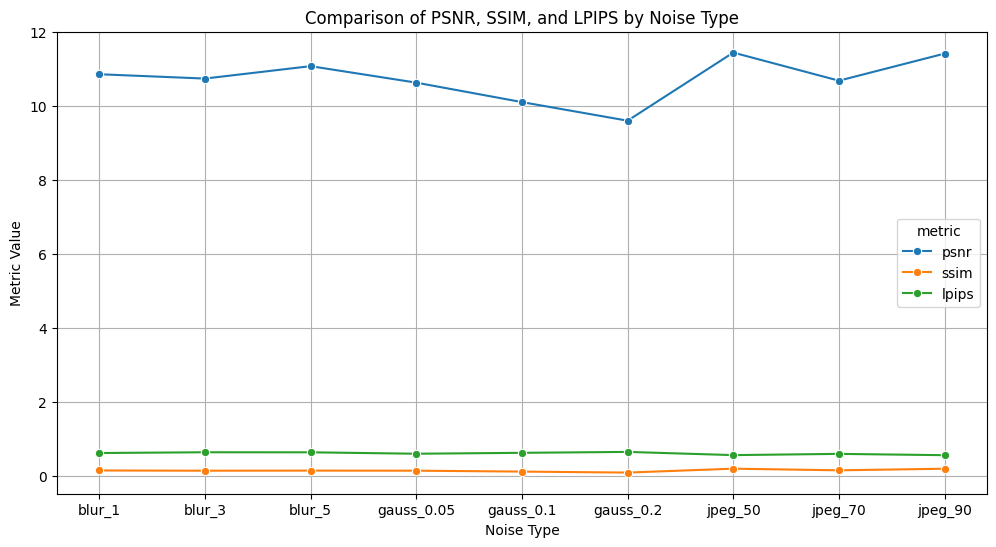

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# The metrics_by_tag DataFrame is already available from the previous cell

# Prepare data for line plots
# We need to melt the dataframe to have metric names as a column
metrics_melted = metrics_by_tag.melt(id_vars='tag', var_name='metric', value_name='value')

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=metrics_melted, x='tag', y='value', hue='metric', marker='o')

plt.title('Comparison of PSNR, SSIM, and LPIPS by Noise Type')
plt.ylabel('Metric Value')
plt.xlabel('Noise Type')
plt.grid(True)
plt.show()

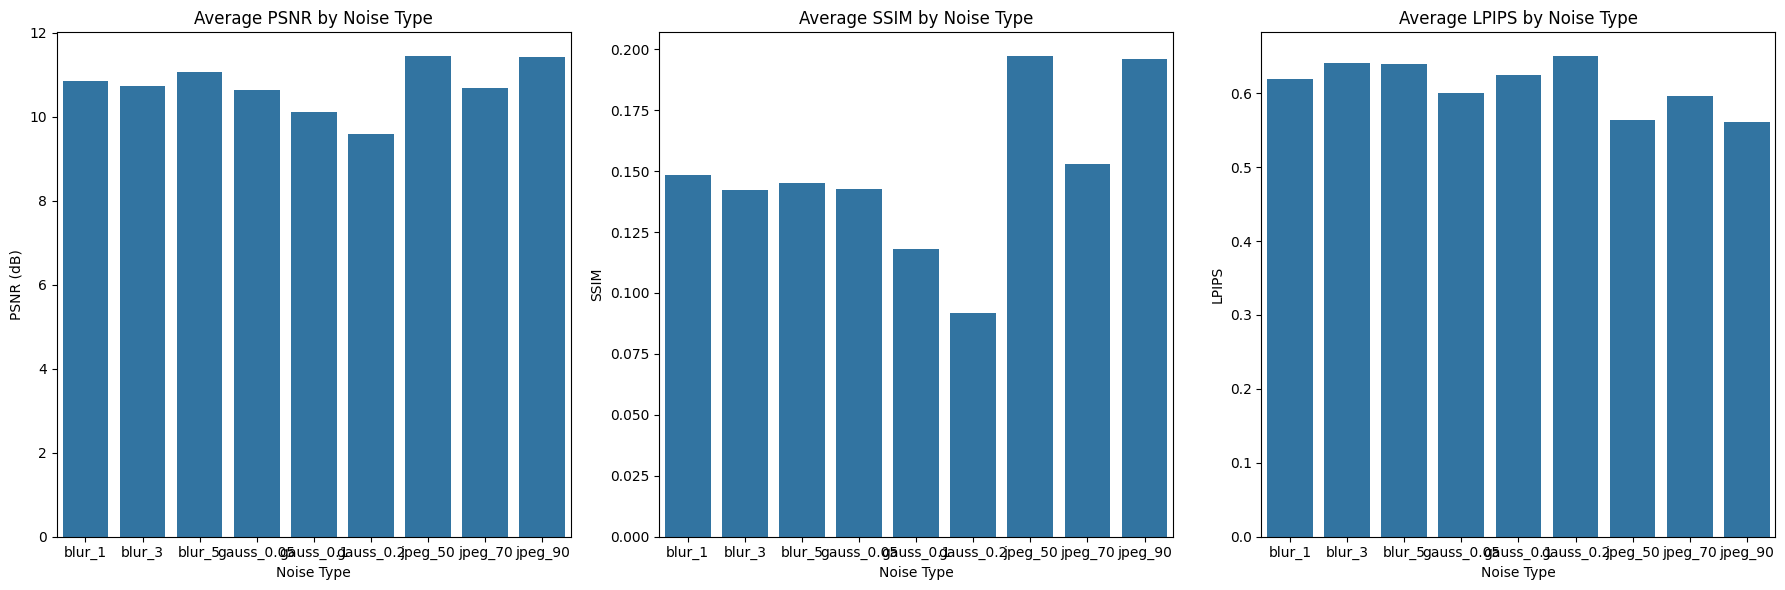

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add metrics to the dataframe for easier plotting
dfv['psnr'] = psnrs
dfv['ssim'] = ssims
dfv['lpips'] = lp_list

# Group by tag and calculate mean metrics
metrics_by_tag = dfv.groupby('tag')[['psnr', 'ssim', 'lpips']].mean().reset_index()

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(x='tag', y='psnr', data=metrics_by_tag, ax=axes[0])
axes[0].set_title('Average PSNR by Noise Type')
axes[0].set_ylabel('PSNR (dB)')
axes[0].set_xlabel('Noise Type')

sns.barplot(x='tag', y='ssim', data=metrics_by_tag, ax=axes[1])
axes[1].set_title('Average SSIM by Noise Type')
axes[1].set_ylabel('SSIM')
axes[1].set_xlabel('Noise Type')

sns.barplot(x='tag', y='lpips', data=metrics_by_tag, ax=axes[2])
axes[2].set_title('Average LPIPS by Noise Type')
axes[2].set_ylabel('LPIPS')
axes[2].set_xlabel('Noise Type')

plt.tight_layout()
plt.show()